In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Load the KDD99 dataset
data = pd.read_csv("kddcup99_csv.csv")

# Define a list of DoS attack names
dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']

# Create a new column 'label' with binary labels
data['label'] = data['label'].apply(lambda x: 1 if x in dos_attacks else 0)

# Identify categorical columns
categorical_columns = ['protocol_type', 'service', 'flag']

# Separate features and labels
X = data.drop('label', axis=1)
y = data['label']

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the OneHotEncoder and MinMaxScaler
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
scaler = MinMaxScaler()

# Encode the categorical columns and create DataFrames with the encoded features
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Get the feature names after encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)

# Create DataFrames with the encoded features and proper column names
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names)

# Drop the original categorical columns from both training and test sets
X_train = X_train.drop(categorical_columns, axis=1)
X_test = X_test.drop(categorical_columns, axis=1)

# Scale the features using Min-Max scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [4]:
# Address class imbalance using RandomUnderSampler
rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

In [5]:
# List of kernel functions to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Initialize dictionaries to store results for each kernel
accuracy_results = {}
precision_results = {}
recall_results = {}
f1_results = {}
roc_auc_results = {}

# Iterate over each kernel and train an SVM model
for kernel in kernels:
    svm_classifier = SVC(kernel=kernel, random_state=42)
    svm_classifier.fit(X_train_resampled, y_train_resampled)
    y_pred = svm_classifier.predict(X_test_scaled)

    # Evaluate the model's performance on the test set
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Store the results in dictionaries
    accuracy_results[kernel] = accuracy
    precision_results[kernel] = precision
    recall_results[kernel] = recall
    f1_results[kernel] = f1
    roc_auc_results[kernel] = roc_auc

# Print the results for each kernel
for kernel in kernels:
    print(f"Kernel: {kernel}")
    print(f"Accuracy: {accuracy_results[kernel]:.2f}")
    print(f"Precision: {precision_results[kernel]:.2f}")
    print(f"Recall: {recall_results[kernel]:.2f}")
    print(f"F1 Score: {f1_results[kernel]:.2f}")
    print(f"ROC AUC: {roc_auc_results[kernel]:.2f}")
    print()

Kernel: linear
Accuracy: 0.99
Precision: 1.00
Recall: 0.99
F1 Score: 1.00
ROC AUC: 1.00

Kernel: rbf
Accuracy: 1.00
Precision: 1.00
Recall: 0.99
F1 Score: 1.00
ROC AUC: 1.00

Kernel: poly
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC: 1.00

Kernel: sigmoid
Accuracy: 0.93
Precision: 0.98
Recall: 0.93
F1 Score: 0.95
ROC AUC: 0.92



In [6]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

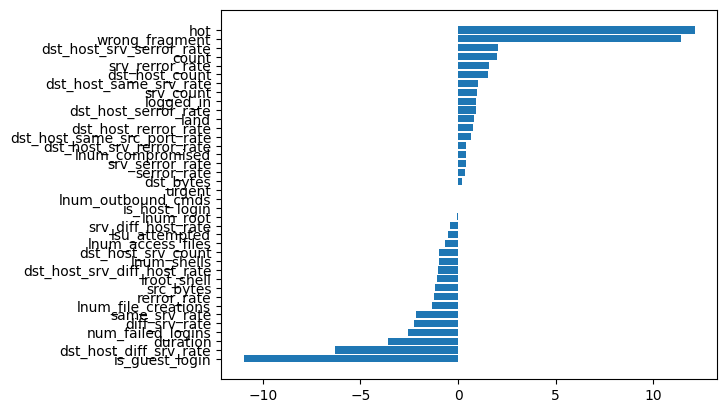

In [7]:
# Plot feature importances
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
coef = svm_model.coef_[0, :]
f_importances(coef, X_train.columns)

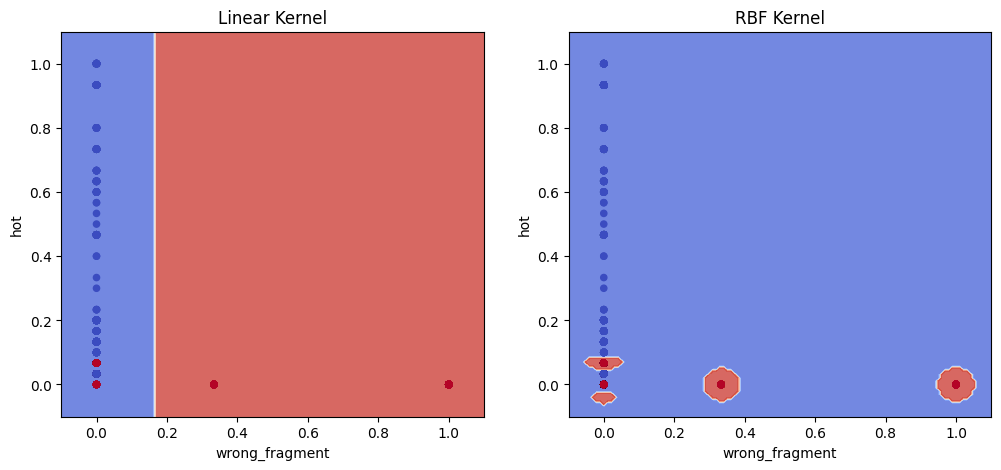

In [8]:
# Visualization with SVM models and decision boundaries
feature1 = 'wrong_fragment'
feature2 = 'hot'
data_subset = data[[feature1, feature2, 'label']]
X = data_subset.drop('label', axis=1)
y = data_subset['label']
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)
X_subsampled, _, y_subsampled, _ = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

svm_linear = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')

svm_linear.fit(X_subsampled, y_subsampled)
svm_rbf.fit(X_subsampled, y_subsampled)

x_min, x_max = X_subsampled[:, 0].min() - 0.1, X_subsampled[:, 0].max() + 0.1
y_min, y_max = X_subsampled[:, 1].min() - 0.1, X_subsampled[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, model, title in zip([0, 1], [svm_linear, svm_rbf], ['Linear Kernel', 'RBF Kernel']):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[i].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    axes[i].scatter(X_subsampled[:, 0], X_subsampled[:, 1], c=y_subsampled, cmap=plt.cm.coolwarm, s=20)
    axes[i].set_xlim(xx.min(), xx.max())
    axes[i].set_ylim(yy.min(), yy.max())
    axes[i].set_xlabel(feature1)
    axes[i].set_ylabel(feature2)
    axes[i].set_title(title)

plt.show()